In [73]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [74]:
import numpy as np
import pandas as pd

In [75]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [76]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [77]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [78]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [79]:
# We can view all of the classes that automap found
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [80]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [81]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [82]:
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x248da37f2c8>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0}

In [83]:
session.query(Station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x248d92c2548>,
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'id': 1}

# Exploratory Climate Analysis

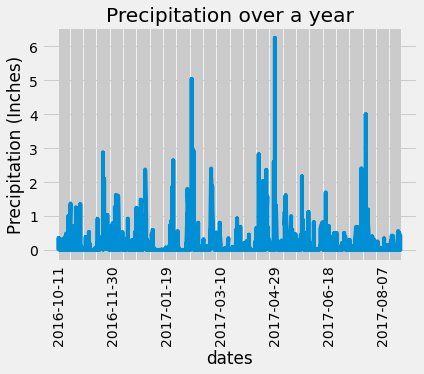

In [84]:
#plot the results

results = session.query(Measurement.prcp,Measurement.date).\
    filter(Measurement.date>dt.datetime(2016,10,10)).\
    filter(Measurement.date<dt.datetime(2017,10,10)).all()\


one_year_df=pd.DataFrame(results, columns=['precipitation', 'date'])
one_year_df=one_year_df.dropna().sort_values('date').reset_index(drop=True)
fig, ax =plt.subplots()
plt.plot(one_year_df['date'],one_year_df['precipitation'])
plt.xticks(rotation='vertical')
plt.title('Precipitation over a year')
plt.xlabel('dates')
plt.ylabel('Precipitation (Inches)')

#Reduce number of x-labels
every_nth=50
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth !=0:
        label.set_visible(False)
plt.show()

In [85]:

# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_df['precipitation'].describe()

count    1737.000000
mean        0.161595
std         0.422694
min         0.000000
25%         0.000000
50%         0.010000
75%         0.120000
max         6.250000
Name: precipitation, dtype: float64

In [86]:
# Design a query to show how many stations are available in this dataset?
results_station_count = session.query(Station.name).count()
results_station_count

9

In [87]:

# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results2 = session.query(Measurement.station).all()
station_counts_df=pd.DataFrame(results2, columns=['stations'])
station_counts=pd.DataFrame({'num':station_counts_df['stations'].value_counts()}).reset_index()
station_counts

,index,num
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [88]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station=station_counts['index'][0]
active_station=session.query(Measurement.tobs).filter(Measurement.station==most_active_station).all()
active_station_temp=pd.DataFrame(active_station,columns=['temp'])

active_station_max=active_station_temp['temp'].max()
active_station_min=active_station_temp['temp'].min()
active_station_avg=round(float(active_station_temp.sum()/len(active_station_temp)),1)
print(f'The maximum temp at {most_active_station} was {active_station_max}')
print(f'The minimum temp at {most_active_station} was {active_station_min}')
print(f'The average temp at {most_active_station} was {active_station_avg}')

The maximum temp at USC00519281 was 85.0
The minimum temp at USC00519281 was 54.0
The average temp at USC00519281 was 71.7


In [89]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_temp_station = session.query(Measurement.tobs,Measurement.date).\
    filter(Measurement.date>dt.datetime(2016,10,10)).\
    filter(Measurement.date<dt.datetime(2017,10,10)).\
    filter(Measurement.station==most_active_station).all()

active_station_temp=pd.DataFrame(results_temp_station,columns=['Temp','Date']).reset_index(drop=True)
#active_station_temp

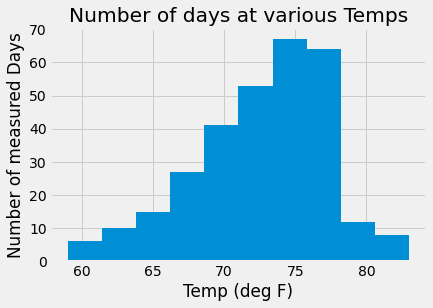

In [90]:
#Plot Histogram of Various Temperatures
fig, ax =plt.subplots()
plt.hist(active_station_temp['Temp'])
plt.title('Number of days at various Temps')
plt.xlabel('Temp (deg F)')
plt.ylabel('Number of measured Days')
plt.show()

In [91]:
from flask import Flask, jsonify

In [31]:
app = Flask(__name__)

#Flask routes
@app.route('/')
def home():
    return (f"Welcome to the Hawaii holiday weather planner!<br/>"
            f"Below are the following repositories of specific weather data<br/>"
            f"<br/>"
            f"/api/v1.0/precipitation<br/>"
            f"/api/v1.0/stations<br/>"
            f"/api/v1.0/tobs<br/>"
            f"/api/v1.0/startingYear_startingMonth_startingDay<br/>"
            f"/api/v1.0/startingYear_startingMonth_startingDay/endingYear_endingMonth_endingDay<br/>"
            f"<br/>"
            f"Make sure to enter your dates in the form YEAR_MONTH_DAY (ex: yyyy_mm_dd)"
            f"<br/>"
            f"Enjoy!")

@app.route('/api/v1.0/precipitation')
def precipitation():
    prec=[]
    for i in range(len(one_year_df['date'])):
        prec_dict={}
        prec_dict["date"]=one_year_df['date'][i]
        prec_dict["Precipitation"]=one_year_df['precipitation'][i]
        prec.append(prec_dict)
    
    return jsonify(prec)

@app.route('/api/v1.0/stations')
def stations():
    station_list=[]
    for name in station_counts['index']:
        st_dict={}
        st_dict['Station ID']=name
        station_list.append(st_dict)
    
    return jsonify(station_list)

@app.route('/api/v1.0/tobs')
def tobs():
    station_temp=[]
    for i in range(len(active_station_temp['Temp'])):
        temp_dict={}
        temp_dict["Temperature"]=active_station_temp['Temp'][i]
        temp_dict['Date']=active_station_temp['Date'][i]
        station_temp.append(temp_dict)
    
    return jsonify(station_temp)

@app.route('/api/v1.0/<start_date>')
def start(start_date):
    session = Session(engine)

    val=start_date.split('_')

    results_start_date = session.query(Measurement.tobs,Measurement.date).\
        filter(Measurement.date>dt.datetime(int(val[0]),int(val[1]),int(val[2]))).all()
    
    results_stdt_df=pd.DataFrame(results_start_date,columns=['Temp','Date'])

    Tmax=results_stdt_df['Temp'].max()
    Tmin=results_stdt_df['Temp'].min()
    Tavg=round(float(results_stdt_df['Temp'].sum()/len(results_stdt_df['Temp'])),1)

    final=[{'Max Temp':Tmax},{'Min Temp':Tmin},{'Average Temp': Tavg}]

    return jsonify(final)
    #return jsonify({"error": "Date not found."}), 404

@app.route('/api/v1.0/<start_date1>/<end_date>')
def end(start_date1, end_date):

    st_val=start_date1.split('_')
    end_val=end_date.split('_')

    results_start_end = session.query(Measurement.tobs,Measurement.date).\
    filter(Measurement.date>dt.datetime(int(st_val[0]),int(st_val[1]),int(st_val[2]))).\
    filter(Measurement.date<dt.datetime(int(end_val[0]),int(end_val[1]),int(end_val[2]))).all()

    results_stend_df=pd.DataFrame(results_start_end,columns=['Temp','Date'])

    Tmax2=results_stend_df['Temp'].max()
    Tmin2=results_stend_df['Temp'].min()
    Tavg2=round(float(results_stend_df['Temp'].sum()/len(results_stend_df['Temp'])),1)

    final2=[{'Max Temp':Tmax2},{'Min Temp':Tmin2},{'Average Temp': Tavg2}]

    return jsonify(final2)

if __name__ == "__main__":
    app.run(debug=False)


## Bonus Challenge Assignment

NameError: name 'session' is not defined